<a href="https://www.kaggle.com/code/hasyimabdillah/workout-classification-inceptionv3?scriptVersionId=136939054" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Necessary Modules & Packages

In [1]:
import os
import cv2
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from datetime import datetime
# from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Set The Hyperparameter

In [2]:
# hyperparameter
height = 256
width = 256
channels = 3
batch_size = 256
img_shape = (height, width, channels)
img_size = (height, width)

# Create, Split, and Check the Dataset

In [3]:
DATA_DIR = '../input/workoutexercises-images'

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       validation_split = 0.1,
                                                       subset = 'training',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       seed = 127
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     validation_split = 0.1,
                                                     subset = 'validation',
                                                     image_size = img_size,
                                                     shuffle = True,
                                                     batch_size = batch_size,
                                                     seed = 127
                                                    )

labels = train_ds.class_names
print(labels)

with open('workout_label.txt', 'w') as f:
    for workout_class in labels:
        f.write(f'{workout_class}\n')

Found 13853 files belonging to 22 classes.
Using 12468 files for training.
Found 13853 files belonging to 22 classes.
Using 1385 files for validation.
['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raises', 'leg extension', 'leg raises', 'plank', 'pull up', 'push up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']


# Augment & Check Train Dataset

In [4]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomBrightness(0.1),
                                         tf.keras.layers.RandomZoom(0.1)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

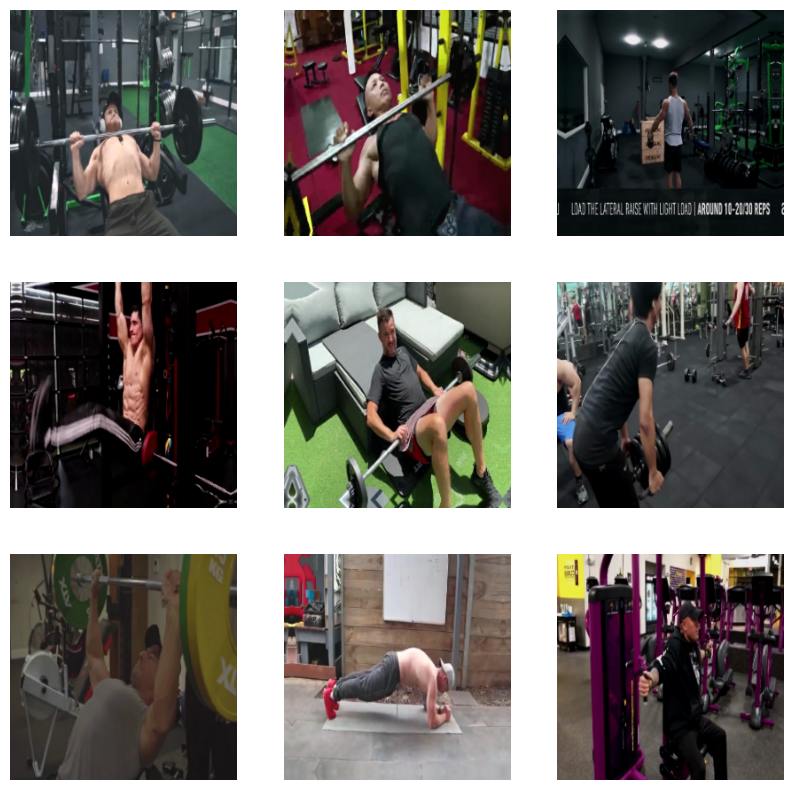

In [5]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

# Create, Compile, Train, and Evaluate The Model

In [6]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [7]:
x = pre_trained.output
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.BatchNormalization()(x)
predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

workout_model = tf.keras.models.Model(inputs = pre_trained.input, 
                                      outputs = predictions
                                     )

workout_model.compile(optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                     )

workout_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

# SMOTE Technique

In [8]:
# x_train = []
# y_train = []

# for images, labels in train_ds:
#     x_train.extend(images.numpy())
#     y_train.extend(labels.numpy())
    
# x_train = np.array(x_train)
# y_train = np.array(y_train)

# x_train = x_train.reshape(x_train.shape[0], -1)

# smote = SMOTE()
# x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Train Model

In [9]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 5, 
                                        mode = 'auto', 
                                        restore_best_weights = True
                                       )

history = workout_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 20
#                             callbacks = [early_stopping_callback]
                           )

Epoch 1/20
49/49 [==============================] - 178s 3s/step - loss: 2.3806 - accuracy: 0.3329 - val_loss: 3.3996 - val_accuracy: 0.2563
Epoch 2/20
49/49 [==============================] - 151s 3s/step - loss: 1.6395 - accuracy: 0.5456 - val_loss: 1.9932 - val_accuracy: 0.4960
Epoch 3/20
49/49 [==============================] - 149s 3s/step - loss: 1.3754 - accuracy: 0.6230 - val_loss: 1.4187 - val_accuracy: 0.6144
Epoch 4/20
49/49 [==============================] - 148s 3s/step - loss: 1.2200 - accuracy: 0.6707 - val_loss: 1.1312 - val_accuracy: 0.6968
Epoch 5/20
49/49 [==============================] - 149s 3s/step - loss: 1.1058 - accuracy: 0.7032 - val_loss: 1.0175 - val_accuracy: 0.7379
Epoch 6/20
49/49 [==============================] - 148s 3s/step - loss: 1.0241 - accuracy: 0.7243 - val_loss: 0.9503 - val_accuracy: 0.7487
Epoch 7/20
49/49 [==============================] - 149s 3s/step - loss: 0.9543 - accuracy: 0.7494 - val_loss: 0.8788 - val_accuracy: 0.7668
Epoch 8/20
49

# Evaluate Model

6/6 [==============================] - 5s 362ms/step - loss: 0.5625 - accuracy: 0.8563


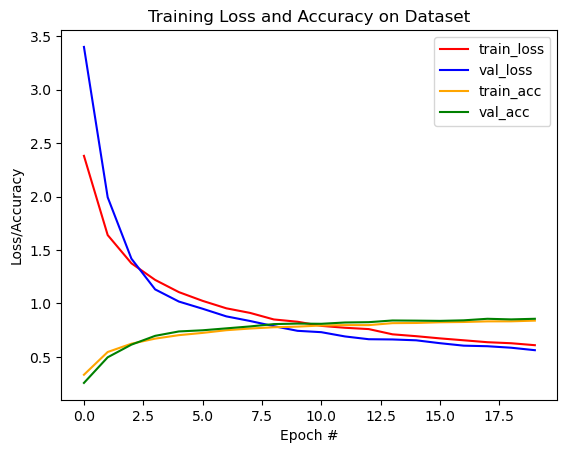

In [10]:
evaluate = workout_model.evaluate(val_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# Save Model History to csv

In [11]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Save and Test The Model to Predict Video

In [12]:
current_datetime = datetime.now()

# Save Model
workout_model.save(f'workout_model_{current_datetime}')

# Save .h5 model
workout_model.save(f'workout_model_{current_datetime}.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(f'./workout_model_{current_datetime}')
tflite_model = converter.convert()

# Save the tflite model
with open(f'workout_model_{current_datetime}.tflite', 'wb') as f:
    f.write(tflite_model)

In [13]:
interpreter = tf.lite.Interpreter(model_path = f'/kaggle/working/workout_model_{current_datetime}.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_1:0
shape: [  1 256 256   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 22]
type: <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [14]:
random_classes_names = random.choice(os.listdir('/kaggle/input/workoutfitness-video'))
random_file = random.choice(os.listdir(f'/kaggle/input/workoutfitness-video/{random_classes_names}'))
print(f'{random_classes_names}/{random_file}\n')

# Construct the input video file path
input_video_file_path = f'/kaggle/input/workoutfitness-video/{random_classes_names}/{random_file}'

# import label from txt file
labels = []
with open('/kaggle/working/workout_label.txt', 'r') as f:
    for row in f:
        labels.append(row)
        

# Initialize video input
video_capture = cv2.VideoCapture(input_video_file_path)
writer = None
H, W = None, None
Q = deque(maxlen=128)
n = 0
img_size = (256, 256)

fps = video_capture.get(cv2.CAP_PROP_FPS)
frame_count = video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
duration = frame_count/fps

print(f'Duration: {duration}')
print(f'FPS: {fps}')
print(f'Total frame: {frame_count}\n')

print('Prediction process')
start_time = time.time()

scan_count = 0
# Loop through each frame in the video
while True:
    # read a frame
    success, frame = video_capture.read()
    
    # if frame not read properly then break the loop
    if not success:
        break
    
    # count the frame
    n += 1
    
    if duration < 5.0:
        # predict every 10 frame (1, 11, 21, ... etc)
        step = 10
    elif duration < 10.0:
        # predict every 15 frame (1, 16, 31, ... etc)
        step = 15
    else:
        # predict every 30 frame (1, 31, 61, ... etc)
        step = 30
    
    if n % step != 1:
        continue
    
    # get frame dimensions
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    
    # clone the frame for the output then preprocess the frame for the prediction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, img_size).astype("float32")
    
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(frame, axis=0))

    interpreter.invoke()

    predictions = interpreter.get_tensor(output_details[0]['index'])[0]
    
    Q.append(predictions)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = labels[i]
    
    text = f'{label}'
#     cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 10)
    
#     if writer is None:
#         fourcc = cv2.VideoWriter_fourcc(*"XVID")
#         writer = cv2.VideoWriter('output.avi', fourcc, 30, (W, H), True)
        
#     writer.write(output)
    
#     plt.imshow(output)
#     plt.axis('off')
    
    print(f'{n}, {text}\t{results[i]}')
    scan_count += 1
    
    target_frame = int(fps*2)
    
    # break the loop if prediction > 90% and video already more than 2 seconds (fps*2)
    if results[i] >= 0.9 and n >= target_frame:
        break

end_time = time.time()

print(f'\nActual video: {random_file}')
print(f'Prediction: {text}')
print(f'confidence: {results[i]}')
print(f'Prediction time: {end_time - start_time} sec')
print(f'Scan speed: {(end_time - start_time)/scan_count} per frame\n')

# writer.release()
# video_capture.release()

result_df = pd.DataFrame({'exercise': labels,
                          'percentage': results
                         })

result_df['exercise'] = result_df['exercise'].str.strip()
result_df = result_df.sort_values('percentage', ascending=False)
result_df = result_df.reset_index(drop=True)

result_df

lateral raise/lateral raise_22.mp4

Duration: 3.5833333333333335
FPS: 24.0
Total frame: 86.0

Prediction process
1, lateral raises
	0.6308954358100891
11, lateral raises
	0.7003483772277832
21, lateral raises
	0.7562486529350281
31, lateral raises
	0.7825651168823242
41, lateral raises
	0.7653181552886963
51, lateral raises
	0.7595352530479431
61, lateral raises
	0.7522759437561035
71, lateral raises
	0.7646757960319519
81, lateral raises
	0.7806808948516846

Actual video: lateral raise_22.mp4
Prediction: lateral raises

confidence: 0.7806808948516846
Prediction time: 2.104505777359009 sec
Scan speed: 0.23383397526211208 per frame



,exercise,percentage
0,lateral raises,0.780681
1,hip thrust,0.065540
2,pull up,0.043346
3,romanian deadlift,0.027758
4,lat pulldown,0.026270
5,bench press,0.014950
6,shoulder press,0.013939
7,hammer curl,0.011374
8,deadlift,0.006494
9,leg raises,0.004024
